# TP4: FINAL 

## On divise les files en 2 parties: avant 1961 et après 1961

In [ ]:
#Division des files en 2 parties avant 1961 et après 1961 
import os
import shutil

input_dir = "C:/Users/duboi/MA2TAC/tac/data/sf"  
output_dir_before = "before_1961"
output_dir_after = "after_1961"

os.makedirs(output_dir_before, exist_ok=True)
os.makedirs(output_dir_after, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        parts = filename.split('_')
        if len(parts) > 2:
            date_part = parts[2]  
            year = int(date_part.split('-')[0])  
            
            src_path = os.path.join(input_dir, filename)
            if year < 1961:
                shutil.move(src_path, os.path.join(output_dir_before, filename))
            else:
                shutil.move(src_path, os.path.join(output_dir_after, filename))
        else:
            print(f"Unexpected filename format: {filename}. Skipping...")

print("Files have been divided based on the year in the filename.")


Unexpected filename format: _README.txt. Skipping...
Files have been divided based on the year in the filename.


## Nettoyage des données dans les deux parties

In [5]:
from collections import Counter
from wordcloud import WordCloud
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duboi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
# Stopwords
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem", "musique", "orchestre", "concert", "programme", "prix", "porte", "anvers", "rue", "très", "président"]
sw = set(sw)


In [ ]:
#Nettoyage de données

def clean_text_in_folder(folder, delete_original=False):
    """
    Cleans all text files in a specified folder.
    Processes each file, tokenizes and filters the text, and saves the cleaned output.
    Optionally deletes the original files after processing.
    """
    if not os.path.exists(folder):
        return f"The folder '{folder}' does not exist."

    for filename in os.listdir(folder):
        if filename.endswith(".txt"):  
            input_path = os.path.join(folder, filename)
            output_path = os.path.join(folder, f"{filename.split('.')[0]}_clean.txt")

            with open(input_path, 'r', encoding='utf-8') as f, open(output_path, 'w', encoding='utf-8') as output:
                text = f.read()
                words = nltk.wordpunct_tokenize(text)
                kept = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
                kept_string = " ".join(kept)
                output.write(kept_string)

            print(f"Cleaned file saved: {output_path}")

            if delete_original:
                os.remove(input_path)
                print(f"Original file deleted: {input_path}")

    return f"All files in the folder '{folder}' have been cleaned!"

folder_before_1961 = "before_1961"  
folder_after_1961 = "after_1961"    

#On supprime les fichiers originaux 
print(clean_text_in_folder(folder_before_1961, delete_original=True))
print(clean_text_in_folder(folder_after_1961, delete_original=True))


Cleaned file saved: before_1961\KB_JB1051_1954-10-29_01-00004_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1954-10-29_01-00004_clean_clean.txt
Cleaned file saved: before_1961\KB_JB1051_1954-12-09_01-00003_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1954-12-09_01-00003_clean_clean.txt
Cleaned file saved: before_1961\KB_JB1051_1955-08-05_01-00002_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1955-08-05_01-00002_clean_clean.txt
Cleaned file saved: before_1961\KB_JB1051_1957-06-20_01-00002_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1957-06-20_01-00002_clean_clean.txt
Cleaned file saved: before_1961\KB_JB1051_1959-03-04_01-00004_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1959-03-04_01-00004_clean_clean.txt
Cleaned file saved: before_1961\KB_JB1051_1959-05-08_01-00002_clean_clean_clean.txt
Original file deleted: before_1961\KB_JB1051_1959-05-08_01-00002_clean_clean.txt
Cleaned fi

## Application de k-means et wordcloud pour les deux parties

In [12]:
import collections
import os
import string
import sys

from collections import Counter
from wordcloud import WordCloud

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\duboi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\duboi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Avant 1961

In [121]:
data_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4/before_1961"
files = [f for f in sorted(os.listdir(data_path)) if f.endswith(".txt")]
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]

print(f"Found {len(files)} files.")
print(f"Read {len(texts)} documents.")

Found 178 files.
Read 178 documents.


In [123]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [122]:
# Instanciation du modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [124]:
tfidf_vectors = vectorizer.fit_transform(texts)
# Détail de la matrice
tfidf_vectors

c:\Users\duboi\MA2TAC\tac\tac_venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<178x3660 sparse matrix of type '<class 'numpy.float64'>'
	with 129763 stored elements in Compressed Sparse Row format>

In [125]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

alimentation    0.198596
con             0.177758
morts           0.175920
libéraux        0.173367
familles        0.173367
                  ...   
fournir         0.000000
fournit         0.000000
foyer           0.000000
fragments       0.000000
lourde          0.000000
Length: 3660, dtype: float64

In [132]:
# Définir le nombre de clusters
N_CLUSTERS = 3

In [133]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [135]:
# Application de clusters
clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

pprint(dict(clustering))

{0: ['KB_JB1051_1954-10-29_01-00004_clean_clean_clean.txt',
     'KB_JB1051_1954-12-09_01-00003_clean_clean_clean.txt',
     'KB_JB1051_1955-08-05_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1957-06-20_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1959-03-04_01-00004_clean_clean_clean.txt',
     'KB_JB1051_1959-05-08_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1959-08-14_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1959-09-25_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1959-10-06_01-00001_clean_clean_clean.txt',
     'KB_JB1051_1960-03-10_01-00001_clean_clean_clean.txt',
     'KB_JB1051_1960-05-20_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1960-07-08_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1960-08-05_01-00002_clean_clean_clean.txt',
     'KB_JB427_1923-04-05_01-00001_clean_clean_clean.txt',
     'KB_JB555_1858-04-26_01-00001_clean_clean_clean.txt',
     'KB_JB555_1895-10-29_01-00001_clean_clean_clean.txt',
     'KB_JB567_1850-08-09_01-00002_clean_cl

In [136]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

reduced_vectors[:10]

array([[-0.11515232, -0.19398037],
       [-0.126617  , -0.1814303 ],
       [-0.02904992, -0.19122431],
       [ 0.05343748, -0.10718866],
       [-0.12827894, -0.21719107],
       [-0.01008957, -0.08344284],
       [-0.00143615, -0.11601651],
       [ 0.03070115, -0.13494419],
       [-0.13704017, -0.24561718],
       [-0.13641497, -0.21016773]])

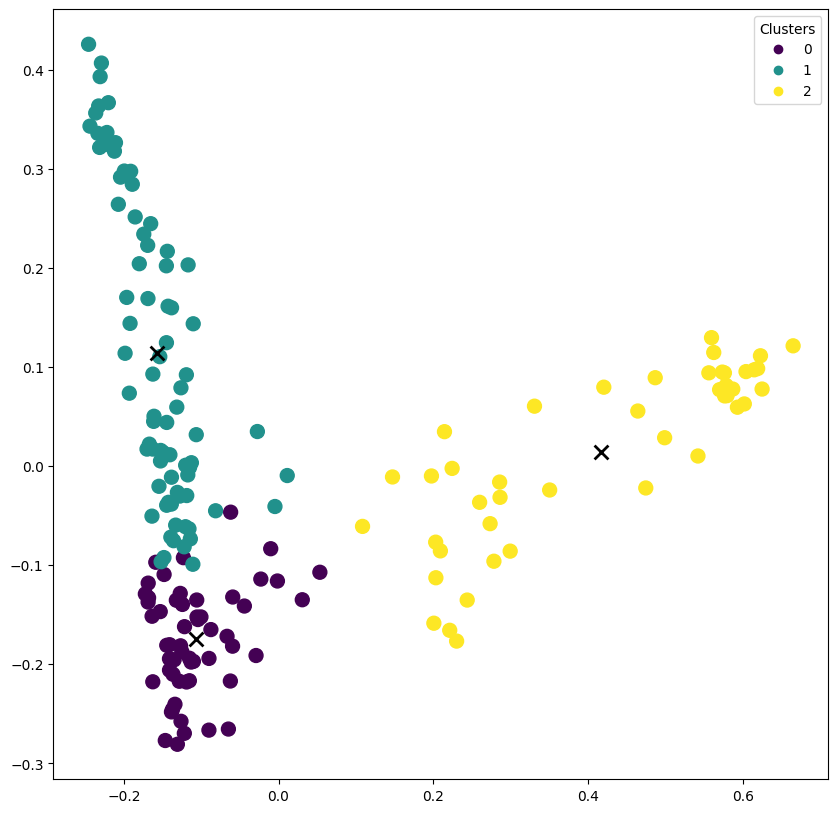

In [137]:
# Génération de plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

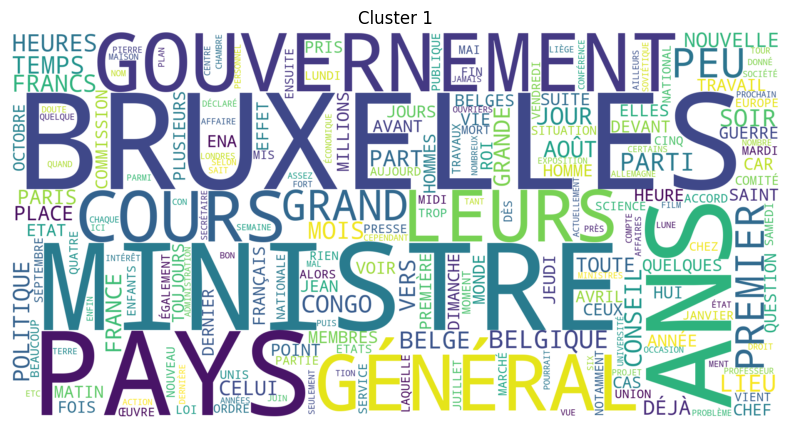

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_1.png


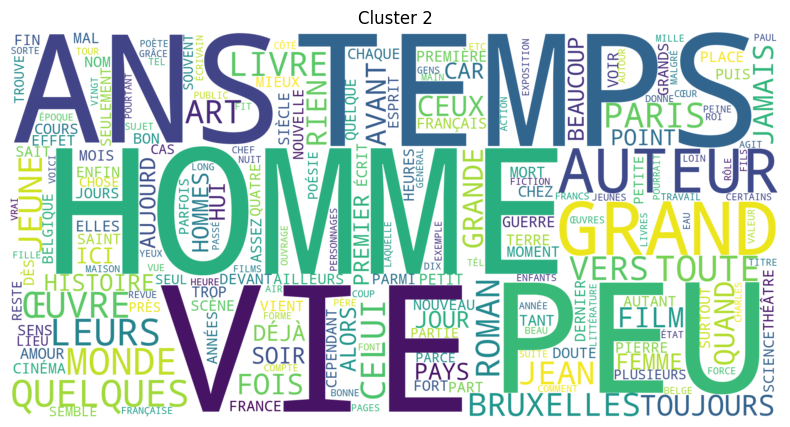

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_2.png


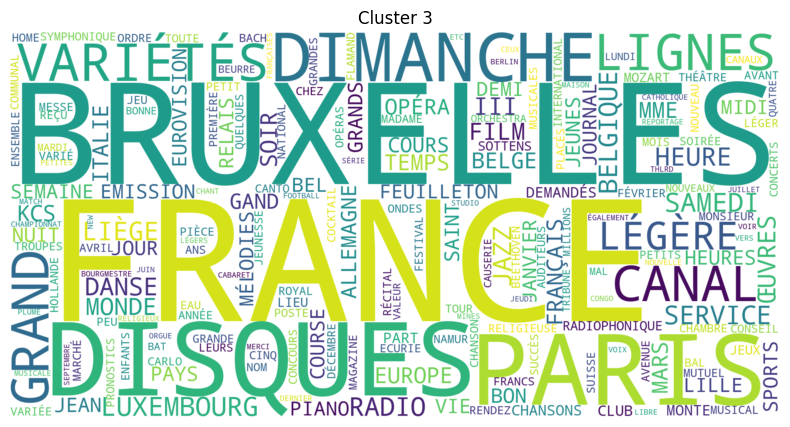

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_3.png


In [ ]:
# Faire un nuage de mots par cluster
output_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for cluster_idx, texts in clustering.items():
   
    cluster_text = " ".join([open(os.path.join(data_path, text), "r", encoding="utf-8").read() for text in texts])

    word_freq = Counter(cluster_text.split()) 
    
    cloud = WordCloud(
        width=2000,
        height=1000,
        background_color='white'
    ).generate_from_frequencies(word_freq)
    
    # Sauver le nuage de mots
    output_file = os.path.join(output_path, f"cluster_{cluster_idx + 1}.png")
    cloud.to_file(output_file)
    
    # Nuages de mots!
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_idx + 1}")
    plt.show()
    print(f"Nuage de mots sauvegardé dans {output_file}")


### Après 1961

In [145]:
data_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4/after_1961"
files = [f for f in sorted(os.listdir(data_path)) if f.endswith(".txt")]
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]

print(f"Found {len(files)} files.")
print(f"Read {len(texts)} documents.")


Found 450 files.
Read 450 documents.


In [146]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [147]:
# Instanciation du modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [148]:
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\duboi\MA2TAC\tac\tac_venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [149]:
# Détail de la matrice
tfidf_vectors

<450x3044 sparse matrix of type '<class 'numpy.float64'>'
	with 271890 stored elements in Compressed Sparse Row format>

In [150]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

reuter      0.716400
unis        0.245457
etats       0.240964
agence      0.227593
lecteurs    0.196338
              ...   
faits       0.000000
fallait     0.000000
fallu       0.000000
fameux      0.000000
œil         0.000000
Length: 3044, dtype: float64

In [280]:
# Définir le nombre de clusters
N_CLUSTERS = 4

In [281]:
km_model = KMeans(n_clusters=N_CLUSTERS)

In [282]:
# Application de clusters
clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

pprint(dict(clustering))

{0: ['BE-KBR00_15463334_19730501_78_00_00_0_01_0047_29575577_clean_clean_clean.txt',
     'KB_JB1051_1961-07-13_01-00004_clean_clean_clean.txt',
     'KB_JB1051_1961-07-14_01-00001_clean_clean_clean.txt',
     'KB_JB1051_1961-08-07_01-00001_clean_clean_clean.txt',
     'KB_JB1051_1961-12-19_01-00003_clean_clean_clean.txt',
     'KB_JB1051_1966-02-14_01-00002_clean_clean_clean.txt',
     'KB_JB1051_1966-03-12_01-00018_clean_clean_clean.txt',
     'KB_JB1051_1966-04-01_01-00003_clean_clean_clean.txt',
     'KB_JB1051_1966-04-13_01-00001_clean_clean_clean.txt',
     'KB_JB838_1961-07-12_01-00003_clean_clean_clean.txt',
     'KB_JB838_1961-09-05_01-00003_clean_clean_clean.txt',
     'KB_JB838_1961-09-06_01-00007_clean_clean_clean.txt',
     'KB_JB838_1961-12-10_01-00006_clean_clean_clean.txt',
     'KB_JB838_1962-02-02_01-00001_clean_clean_clean.txt',
     'KB_JB838_1962-02-24_01-00001_clean_clean_clean.txt',
     'KB_JB838_1962-05-12_01-00001_clean_clean_clean.txt',
     'KB_JB838_1962-05

In [283]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

reduced_vectors[:10]

array([[-0.09291145, -0.00917243],
       [-0.00590704, -0.02294455],
       [-0.07769492, -0.04764635],
       [-0.0163255 , -0.01358939],
       [-0.11491139,  0.00704932],
       [ 0.01350631, -0.05155678],
       [ 0.07771802,  0.16415776],
       [-0.23356183, -0.02966115],
       [-0.22265893, -0.02071438],
       [-0.19226277, -0.02758462]])

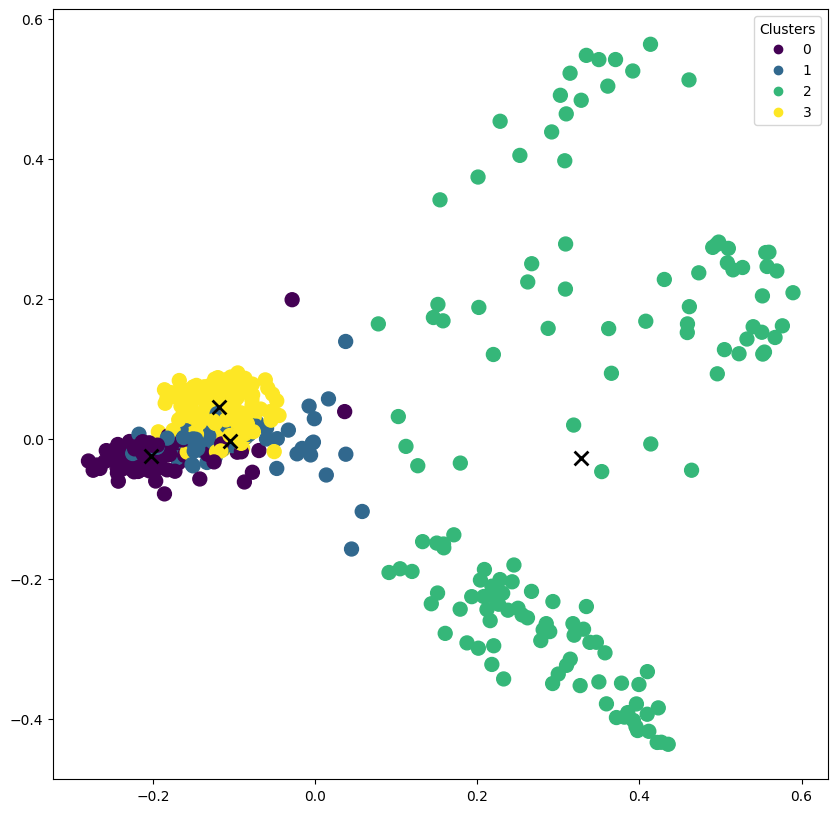

In [284]:
# Génération de plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

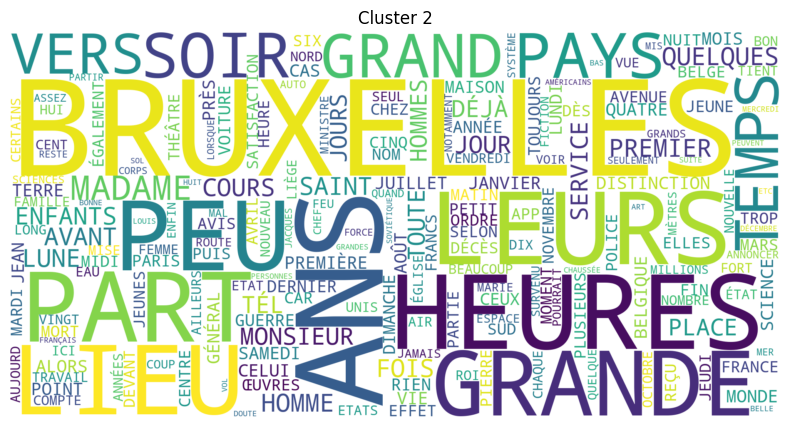

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_2.png


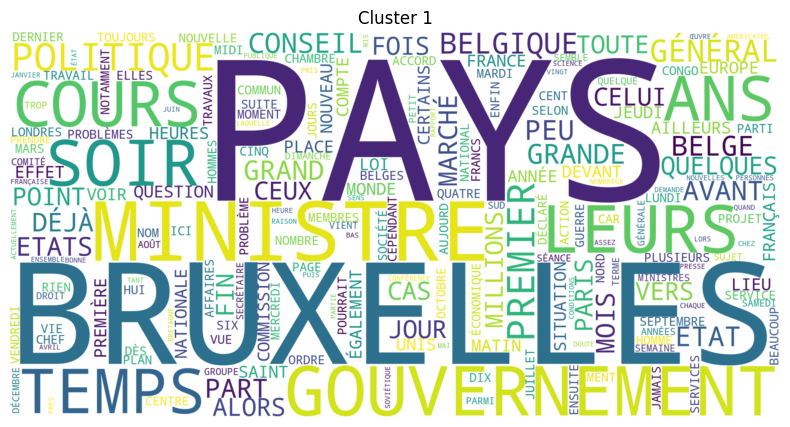

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_1.png


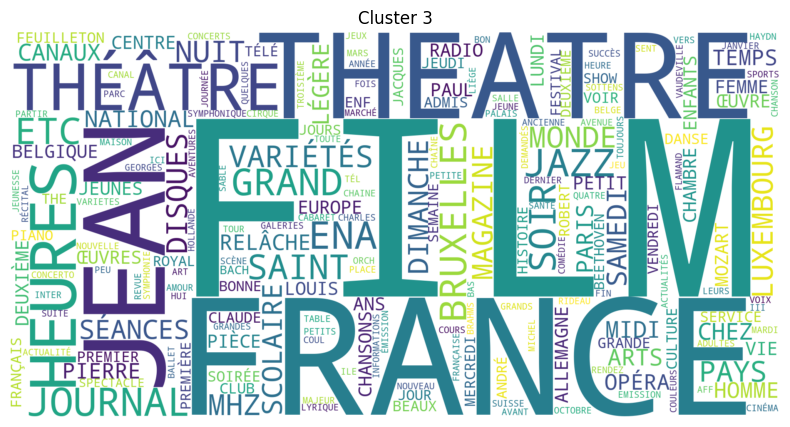

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_3.png


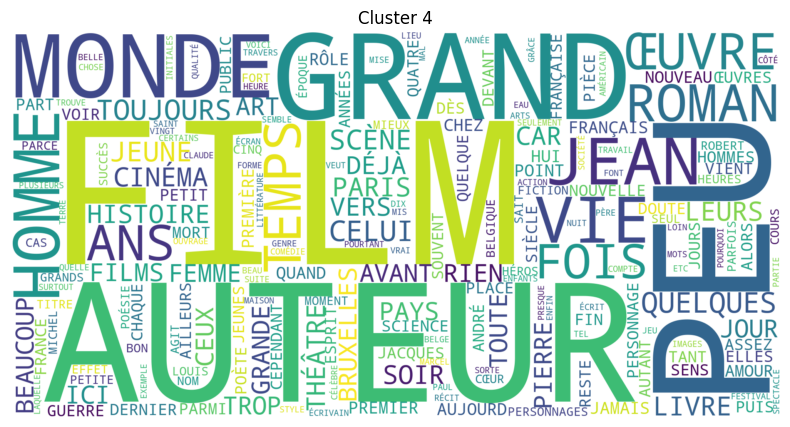

Nuage de mots sauvegardé dans C:/Users/duboi/MA2TAC/tac/tps/tp4\cluster_4.png


In [ ]:
# Faire un nuage de mots par cluster
output_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for cluster_idx, texts in clustering.items():
   
    cluster_text = " ".join([open(os.path.join(data_path, text), "r", encoding="utf-8").read() for text in texts])

    word_freq = Counter(cluster_text.split()) 
    
    cloud = WordCloud(
        width=2000,
        height=1000,
        background_color='white'
    ).generate_from_frequencies(word_freq)
    
    # Sauver le nuage de mots
    output_file = os.path.join(output_path, f"cluster_{cluster_idx + 1}.png")
    cloud.to_file(output_file)
    
    # Nuages de mots!
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_idx + 1}")
    plt.show()
    print(f"Nuage de mots sauvegardé dans {output_file}")


## Modèle word2vec

### Après 1961

In [ ]:
import os

# Création d'un fichier txt master
after_1961_folder = "C:/Users/duboi/MA2TAC/tac/tps/tp4/after_1961"
master_file_path = "after_1961_master.txt"  

with open(master_file_path, "w", encoding="utf-8") as master_file:
    
    for filename in os.listdir(after_1961_folder):
        if filename.endswith(".txt"):  
            file_path = os.path.join(after_1961_folder, filename)
            
            with open(file_path, "r", encoding="utf-8") as current_file:
                content = current_file.read()
                
                master_file.write(content + "\n\n")  

print(f"All text files have been combined into: {master_file_path}")


All text files have been combined into: after_1961_master.txt


In [25]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

In [240]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

infile = f"C:/Users/duboi/MA2TAC/tac/tps/tp4/after_1961_master.txt"
sentences = MySentences(infile)

In [241]:
bigram_phrases = Phrases(sentences)

In [242]:
type(bigram_phrases.vocab)

dict

In [243]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [244]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [245]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [247]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])
print(corpus[:100])

[['urss', 'gouts', 'lecteur', 'sovietique', 'occasion', 'cinquantieme', 'anniversaire', 'izvestia', 'publie', 'recemment', 'resultats', 'lecteurs', 'presse', 'sovietique', 'pres', 'reponses', 'depouillees', 'ressort', 'seulement', 'lecteurs', 'lisent', 'editoriaux', 'presse', 'union_sovietique', 'refletent', 'ralement', 'opinion', 'gouvernementale', 'lecteur', 'sovietique', 'recherche', 'particulierement', 'tribunes', 'libres', 'revolution', 'octobre', 'enquete', 'effectuee', 'aupres', 'sujets', 'controverses', 'puis', 'rubrique', 'science_fiction', 'nouvelles', 'politique_etrangere', 'informations', 'sportives', 'seulement', 'lecteurs', 'declarent', 'interesser', 'articles', 'economiques', 'izvestia', 'personnes', 'ans', 'constituent', 'majorite', 'lecteurs', 'lecteurs', 'ans', 'constituant', 'clientele', 'totale', 'usa', 'agence', 'reuter', 'cree', 'propre', 'reseau', 'informations', 'etats_unis', 'agence', 'britannique', 'reuter', 'agence', 'americaine', 'associated', 'press', 'mis'

In [246]:
bigram_phrases = Phrases(sentences1, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_phrases)
trigram_phrases = Phrases(bigram_phraser[sentences1], min_count=5, threshold=10)
trigram_phraser = Phraser(trigram_phrases)
corpus = list(trigram_phraser[bigram_phraser[sentences1]])


In [248]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 4.81 s
Wall time: 4.1 s


In [249]:
outfile = f"C:/Users/duboi/MA2TAC/tac/data/after_1961.model" 
model.save(outfile)

In [250]:
model = Word2Vec.load("C:/Users/duboi/MA2TAC/tac/data/after_1961.model")

In [251]:
model.wv.most_similar("science_fiction", topn=20)

[('images', 0.9261904954910278),
 ('films', 0.9097667932510376),
 ('parle', 0.9033374190330505),
 ('tourne', 0.8978827595710754),
 ('monde', 0.8932496905326843),
 ('allemand', 0.8917298913002014),
 ('jeu', 0.8885391354560852),
 ('americain', 0.8800169825553894),
 ('fantastique', 0.8790232539176941),
 ('vie', 0.8780799508094788),
 ('livre', 0.8765767216682434),
 ('histoire', 0.875916063785553),
 ('anglais', 0.8726057410240173),
 ('long_metrage', 0.8725512623786926),
 ('realisateur', 0.8722484111785889),
 ('epouvante', 0.863284170627594),
 ('inegal', 0.8500047922134399),
 ('meilleur', 0.8479212522506714),
 ('risi', 0.8445637822151184),
 ('grandes_personnes', 0.8439648151397705)]

In [252]:
model.wv.similarity("science_fiction", "realite")

0.6900779

In [253]:
model.wv.similarity("science_fiction", "progres" )

0.5364355

In [254]:
model.wv.similarity("science_fiction", "espace" )

0.6380096

### Avant 1961

In [ ]:
# Création d'un fichier master.txt
after_1961_folder = "C:/Users/duboi/MA2TAC/tac/tps/tp4/before_1961"
master_file_path = "before_1961_master.txt" 

with open(master_file_path, "w", encoding="utf-8") as master_file:
    
    for filename in os.listdir(after_1961_folder):
        if filename.endswith(".txt"):  
            file_path = os.path.join(after_1961_folder, filename)
        
            with open(file_path, "r", encoding="utf-8") as current_file:
                content = current_file.read()
                
                
                master_file.write(content + "\n\n")  

print(f"All text files have been combined into: {master_file_path}")


All text files have been combined into: before_1961_master.txt


In [231]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

infile = f"C:/Users/duboi/MA2TAC/tac/tps/tp4/before_1961_master.txt"
sentences1 = MySentences(infile)

In [232]:
bigram_phrases = Phrases(sentences1)

In [233]:
type(bigram_phrases.vocab)

dict

In [234]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [235]:
trigram_phrases = Phrases(bigram_phraser[sentences1])

In [236]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [237]:
corpus = list(trigram_phraser[bigram_phraser[sentences1]])
print(corpus[:100])

[['turuiai', 'nec', 'rea', 'hwsiii', 'ncd', 'jour', 'ira', 'lot', 'apre', 'toot', 'voir', 'bonne', 'flfore', 'congolais', 'billets', 'impression', 'bonne', 'cenrre', 'venir', 'aide', 'pauvres', 'certain', 'loterie', 'rapporte', 'importantes', 'hais', 'argent', 'savent', 'sait_quelle', 'question', 'depute', 'pac', 'bulletin', 'parlementaire', 'leve', 'petit', 'coin', 'voile', 'quelles', 'subventions', 'allouees', 'departement', 'loterie_coloniale', 'cercle', 'colonial', 'hal', 'ponr', 'erection', 'fort', 'louable', 'soi', 'monument', 'roi', 'leenold', 'pare', 'communal', 'hal', 'eeremonta', 'inauguration', 'dimanche', 'sep', 'quoi', 'ministre_colonies', 'repond', 'subside', 'francs', 'accorde', 'cercle', 'lonial', 'hal', 'arrete_ministeriel', 'aout', 'ministre', 'discret', 'origine', 'fonds', 'question', 'depute', 'initie', 'lais', 'supposer', 'parmi', 'beneficiaires', 'loterie_coloniale', 'pourrait', 'negres', 'blancs', 'thyl', 'salerne', 'ravagee', 'ouragan', 'pres', 'cinq_cents', 'mo

In [222]:
bigram_phrases = Phrases(sentences1, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_phrases)
trigram_phrases = Phrases(bigram_phraser[sentences1], min_count=5, threshold=10)
trigram_phraser = Phraser(trigram_phrases)
corpus = list(trigram_phraser[bigram_phraser[sentences1]])


In [223]:
%%time
model1 = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 2.09 s
Wall time: 2.02 s


In [224]:
outfile = f"C:/Users/duboi/MA2TAC/tac/data/before_1961.model" 
model1.save(outfile)

In [225]:
model1 = Word2Vec.load("C:/Users/duboi/MA2TAC/tac/data/before_1961.model")

In [259]:
model1.wv.most_similar("science_fiction", topn=20)

[('coeur', 0.9996570348739624),
 ('agit', 0.9996469020843506),
 ('esprit', 0.9996383190155029),
 ('roman', 0.999634325504303),
 ('role', 0.9996092915534973),
 ('derniers', 0.9996039867401123),
 ('cesse', 0.9996020197868347),
 ('ouvrage', 0.9995967149734497),
 ('trouver', 0.9995953440666199),
 ('parler', 0.999595046043396),
 ('marque', 0.9995898008346558),
 ('jeux', 0.9995759129524231),
 ('pourrait', 0.9995730519294739),
 ('force', 0.9995700716972351),
 ('reste', 0.999566376209259),
 ('bas', 0.9995589256286621),
 ('autour', 0.9995586276054382),
 ('histoire', 0.9995531439781189),
 ('certaines', 0.9995524287223816),
 ('mots', 0.9995478987693787)]

In [260]:
model1.wv.similarity("science_fiction", "realite")

0.9992717

In [261]:
model1.wv.similarity("science_fiction", "progres")

0.99902546

In [262]:
model1.wv.similarity("science_fiction", "espace")

0.9994218

## Entités nommées

In [263]:
from collections import defaultdict
import os
import spacy

# Charger le modèle de langue français de spaCy
!python -m spacy download fr_core_news_md
nlp = spacy.load('fr_core_news_md')


[notice] A new release of pip is available: 23.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 45.8/45.8 MB 3.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


### Avant 1961

In [264]:
#Définition du chemin
txt_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4/before_1961"

In [265]:
files = [f for f in os.listdir(txt_path) if f.endswith('.txt')]

In [ ]:
# Charger le contenu des fichiers texte
text = ""
for f in files:
    with open(os.path.join(txt_path, f), 'r', encoding='utf-8') as file:
        text += file.read() + " "
# Limiter la taille du texte 
n = 1000000  # Limite de caractères à traiter
text = text[:n]

In [269]:
# Traiter le texte avec spaCy pour extraire les entités nommées
doc = nlp(text)

# Compter les entités nommées
people = defaultdict(int)
organizations = defaultdict(int)
locations = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:  # Personnes
        people[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:  # Organisations
        organizations[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:  # Lieux
        locations[ent.text] += 1

In [270]:
# Trier les entités nommées par fréquence et imprimer les principales pour chaque catégorie
print("\nPersonnes les plus fréquentes :")
sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois")



Personnes les plus fréquentes :
VOUÉE INSUCCÈS apparait 1 fois
LEE CHAMPIONNATS apparait 1 fois
LIBRE BEL apparait 1 fois
DÉRAPA apparait 1 fois
LEE ENTRES apparait 1 fois
JACQUES BREL apparait 1 fois
AUBERGE BONHEUR MENTY apparait 1 fois
DUCAUX BLANCHETTE apparait 1 fois
FAUDRA CORE apparait 1 fois
KINOX MOLENBEEK ENO apparait 1 fois
LANCIER POETE NAMUR FTE apparait 1 fois
LOUIS MAJOR apparait 1 fois
CHÔMEUR SUPPLÉMENT apparait 1 fois
LICENCIÉE FER apparait 1 fois
SURVIVANTS IRETROUVE apparait 1 fois
LOUIS NIERA apparait 1 fois
SAUVETEURS apparait 1 fois
HENRI VLÉ MICHÈLE apparait 1 fois
VILLARD BELLA VISCONTI apparait 1 fois
PRISONNIER apparait 1 fois
LOUIS LLDO apparait 1 fois
HANSEN apparait 1 fois
BOSSU POUSSA apparait 1 fois
JOUI INTERMINABLE apparait 1 fois
DAMNÉ apparait 1 fois
RÉVOQUÉE apparait 1 fois
CAGLIARI OPPOSE apparait 1 fois
DÉPLORABLE SIGNALÉ apparait 1 fois
INDÉFINIMENT apparait 1 fois
LÉGÈRES apparait 1 fois
SMETS MONDT apparait 1 fois
FEU LOUVRES apparait 1 fois
F

In [271]:
print("\nLieux les plus fréquents :")
sorted_locations = sorted(locations.items(), key=lambda kv: kv[1], reverse=True)
for loc, freq in sorted_locations[:50]:
    print(f"{loc} apparait {freq} fois")


Lieux les plus fréquents :
TERRE apparait 5 fois
CONGO apparait 4 fois
MONS apparait 4 fois
DEVRA apparait 2 fois
CONQUIS GARE NORD GARE apparait 2 fois
FRANCE apparait 2 fois
SIBLE apparait 1 fois
FAUTES apparait 1 fois
LINL apparait 1 fois
HELLEMONT apparait 1 fois
BRUXELLOIS apparait 1 fois
ITALIE apparait 1 fois
OIMANCHI apparait 1 fois
GIINEUR apparait 1 fois
CHARBONNAGE apparait 1 fois
BISET apparait 1 fois
REVENDI apparait 1 fois
LARATISME apparait 1 fois
COLLA HOUGARDY CLAMER apparait 1 fois
IGNORÉ CALAI apparait 1 fois
AFRICAINS LUTTENT apparait 1 fois
ÉCHEVIN VIEILLE apparait 1 fois
LUNE NARD apparait 1 fois
MENT BRANKART apparait 1 fois
CUBA apparait 1 fois
BOSSU DOUTE RÉPONDIT GRIVEAU apparait 1 fois
CONDITIONS apparait 1 fois
AMORCER apparait 1 fois
ACTUELS apparait 1 fois
HÉSITERA apparait 1 fois
ROEULX apparait 1 fois
ADJU apparait 1 fois
PLAINDRE apparait 1 fois
RÉRIEAX apparait 1 fois
DIRA apparait 1 fois
ALLESIOA apparait 1 fois
CRÉE apparait 1 fois
LOUBET LOUBET DÉS

In [272]:
print("\nOrganisations les plus fréquentes :")
sorted_organizations = sorted(organizations.items(), key=lambda kv: kv[1], reverse=True)
for org, freq in sorted_organizations[:50]:
    print(f"{org} apparait {freq} fois")



Organisations les plus fréquentes :
TOUTE apparait 31 fois
SIEUR apparait 13 fois
TEUR apparait 10 fois
ORGANISÉ apparait 10 fois
BELG apparait 9 fois
PARTICULIÈREMENT apparait 8 fois
RUSSIE apparait 8 fois
CONDAMNÉ apparait 7 fois
ALLEMAGNE apparait 7 fois
ANDERLECHT apparait 7 fois
PARC apparait 7 fois
FOULE apparait 7 fois
FAISAIT apparait 7 fois
SPHÈRE apparait 7 fois
GAND apparait 6 fois
RÉCEPTEUR apparait 6 fois
SIEURS apparait 6 fois
DIRIGÉ apparait 6 fois
AUSSITÔT apparait 6 fois
APPARAÎT apparait 6 fois
USINES apparait 6 fois
ENRICO apparait 6 fois
DUQUEL apparait 5 fois
SÉNATEUR apparait 5 fois
ÉTALENT apparait 5 fois
ROUTE apparait 5 fois
POURSUIVENT apparait 5 fois
PATHÉ apparait 5 fois
INSTITUT apparait 5 fois
TÉMOINS apparait 5 fois
EUROPE apparait 5 fois
TROUVAIENT apparait 5 fois
VIOLENT apparait 5 fois
QUITTÉ apparait 5 fois
FANTÔMES apparait 5 fois
VERDEYHEN apparait 5 fois
AGNÈS apparait 5 fois
RÉPOND apparait 4 fois
SOUCOUPES apparait 4 fois
RETROUVÉ apparait 4 foi

### Après 1961

In [273]:
#Définition du chemin
txt_path = "C:/Users/duboi/MA2TAC/tac/tps/tp4/after_1961"

In [274]:
files = [f for f in os.listdir(txt_path) if f.endswith('.txt')]

In [275]:
# Charger le contenu des fichiers texte
text = ""
for f in files:
    with open(os.path.join(txt_path, f), 'r', encoding='utf-8') as file:
        text += file.read() + " "
# Limiter la taille du texte 
n = 1000000  # Limite de caractères à traiter
text = text[:n]

In [276]:
# Traiter le texte avec spaCy pour extraire les entités nommées
doc = nlp(text)

# Compter les entités nommées
people = defaultdict(int)
organizations = defaultdict(int)
locations = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:  # Personnes
        people[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:  # Organisations
        organizations[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:  # Lieux
        locations[ent.text] += 1

In [277]:
# Trier les entités nommées par fréquence et imprimer les principales pour chaque catégorie
print("\nPersonnes les plus fréquentes :")
sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois")



Personnes les plus fréquentes :
LOUIS JAUNLAUX apparait 2 fois
GROBBENDONK apparait 1 fois
VIEMME MARIE apparait 1 fois
AVENUE COCAGNE apparait 1 fois
LEE FAN MER apparait 1 fois
SPÉCIAL LIBRE apparait 1 fois
SCIEN apparait 1 fois
JUGI APPARENCES apparait 1 fois
VIEUX GÉNÉRAL apparait 1 fois
CARDI NAUX apparait 1 fois
FCLTLLOOLUITO TRÉTEAUX apparait 1 fois
LOUIS VERNEUIL PEINTURE apparait 1 fois
TEDDY WIL apparait 1 fois
LEE ORGANISATIONS apparait 1 fois
CHOPIN FRANCK apparait 1 fois
FAUDRA ARRIVER apparait 1 fois
SOUP apparait 1 fois
LOUIS JUT apparait 1 fois
RIRE CAVIAR apparait 1 fois
BLAGÈA FRIT apparait 1 fois
CHOPIN SCHUBERT apparait 1 fois
LOUIS BLNNE apparait 1 fois
RÉPOND CERTAINE apparait 1 fois
LEIER SCIAMMENT apparait 1 fois
BLO QUOLQUOS apparait 1 fois
BRE JUMET APPUIE apparait 1 fois
LOUIS GILKENS apparait 1 fois
PENSE BREL TAMMENT apparait 1 fois
LEE INDES apparait 1 fois
ROGIER apparait 1 fois
LOUIS JOUVET apparait 1 fois
MARTZ TROUVAIT apparait 1 fois
CHRISTIAN MARQNO

In [278]:
print("\nLieux les plus fréquents :")
sorted_locations = sorted(locations.items(), key=lambda kv: kv[1], reverse=True)
for loc, freq in sorted_locations[:50]:
    print(f"{loc} apparait {freq} fois")


Lieux les plus fréquents :
CONGO apparait 7 fois
GRANDE BRETAGNE ASSOCIATED PRESS apparait 2 fois
DIAPOSITIVES apparait 2 fois
DISPONIBLE apparait 2 fois
RONT apparait 2 fois
VEDETTE apparait 2 fois
SEMBLE apparait 2 fois
OPÉRETTE apparait 2 fois
KOPIJ apparait 1 fois
HEEFT apparait 1 fois
OBERBAYERN apparait 1 fois
VÉNUS apparait 1 fois
TTEL MOGADOR apparait 1 fois
RÉCLAME apparait 1 fois
CITÉE apparait 1 fois
PARVENIR apparait 1 fois
NUIT NOVELTY apparait 1 fois
BORINAGE apparait 1 fois
POPU apparait 1 fois
CUBA apparait 1 fois
ENA VIEUX KUHN apparait 1 fois
LEINS EPHANÉRLDËS apparait 1 fois
ELAT UNLS apparait 1 fois
RAILÎIU apparait 1 fois
REVENUS apparait 1 fois
AIN CONSEILLER COMMUNAL apparait 1 fois
AJACCIO apparait 1 fois
AVENIR apparait 1 fois
RISME SOCIAL RÉUNI apparait 1 fois
NYMPLIETTES apparait 1 fois
ESPION apparait 1 fois
HEURES apparait 1 fois
DOFFERBK apparait 1 fois
ACEC apparait 1 fois
POMMER apparait 1 fois
BRÛLER apparait 1 fois
VIEUX SAGE VIEUX PROFESSEUR CHO appa

In [279]:
print("\nOrganisations les plus fréquentes :")
sorted_organizations = sorted(organizations.items(), key=lambda kv: kv[1], reverse=True)
for org, freq in sorted_organizations[:50]:
    print(f"{org} apparait {freq} fois")



Organisations les plus fréquentes :
TOUTE apparait 20 fois
ALLEMAGNE apparait 9 fois
EUROPE apparait 8 fois
SPECTATEUR apparait 8 fois
TIRÉ apparait 7 fois
PARTICULIÈREMENT apparait 7 fois
LENTE apparait 7 fois
SOVIÉTIQUES apparait 7 fois
DUQUEL apparait 7 fois
PROBABLEMENT apparait 7 fois
SOTTENS apparait 7 fois
AGENCE apparait 6 fois
FRANÇAIS apparait 6 fois
QUES apparait 6 fois
APPARAÎT apparait 6 fois
AJOUTE apparait 6 fois
MICHÈLE apparait 6 fois
VOUA apparait 6 fois
LOUISE apparait 6 fois
SÉNATEUR apparait 6 fois
FEUILLETON apparait 6 fois
DOUANIERS apparait 6 fois
ANDERLECHT apparait 5 fois
ORGUE apparait 5 fois
MÈNENT apparait 5 fois
VANT apparait 5 fois
KHROUCHTCHEV apparait 5 fois
PARC apparait 5 fois
ÉTALENT apparait 5 fois
REMARQUABLE apparait 5 fois
THÉO apparait 5 fois
BRAEKMAN apparait 5 fois
ÉCRIVAIN apparait 5 fois
TEREZA apparait 5 fois
ESSENTIELLEMENT apparait 5 fois
MUNI apparait 5 fois
SOUCIEUX apparait 5 fois
THLRD apparait 5 fois
PAGINA apparait 4 fois
TÉLÉSPECT